# Barrier Option simulation

In [1]:
import os 
import numpy as np
import pandas as pd
import decimal
from datetime import datetime
import plotly
import plotly.graph_objs as go
import plotly.express as px
import time
import math
import matplotlib.pyplot as plt
import mplfinance as fplt

############################################ CONFIG ############################################ 
os.environ['TZ'] = 'UTC' 
################################################################################################
%reload_ext watermark
%watermark -v -p numpy,pandas

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy : 1.19.2
pandas: 1.2.0



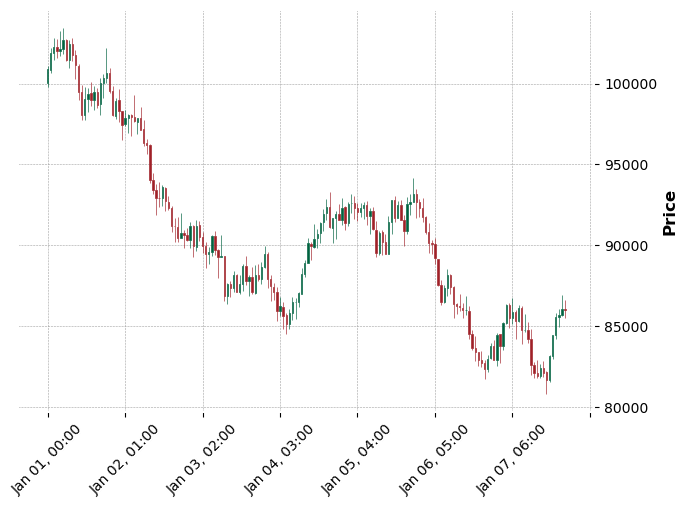

In [2]:
# For GBM:

S0 = 100000
t = 7 * 86400/86400/365
mu = 0
dt = 1/86400/365
steps = t/dt
sigma = 1

# GBM without JUMP
drift = np.ones(int(steps)) * (mu - 0.5 * sigma ** 2) * dt
randomness = np.random.normal(0, 1, int(steps)) * sigma * np.sqrt(dt)
paths = S0 * np.exp(np.cumsum(drift + randomness))
df = pd.DataFrame(
    {'ts': pd.date_range('2021-01-01', '2021-02-01', freq = 's')[0:int(steps)],
     'spot': paths}).set_index('ts')

df_candle = df.groupby(pd.Grouper(freq = '1H')).agg(Open  = ('spot', 'first'),
                                                    High = ('spot', 'max'),
                                                    Low = ('spot', 'min'),     
                                                    Close = ('spot', 'last'))


fplt.plot(df_candle, type='candle', style='charles')

# Helper Function for GBM path

In [3]:
def gbm_simulation(S0, K, t, dt, r, sigma, typeFlag):
    steps = t/dt
    rands = np.random.normal(0, 1, int(steps))
    standard_sum = np.arange(1, steps + 1, 1)
    rands_cumsum  = np.cumsum(rands)
    # Log returns are addictive, hence:
    paths = (S0 * np.exp(standard_sum * ((r - 0.5 * sigma ** 2) * dt) + sigma * np.sqrt(dt) * rands_cumsum))
    if typeFlag == "c":
        return paths[-1], max(paths[-1] - K, 0)
    elif typeFlag == "p":
        return paths[-1], max(K -paths[-1], 0)

# Helper Function for Path-Dependent Random Walk Simulation

In [4]:
def pip_size_name(S, B, pip_size):
    if S == B:
        return '+0'
    elif S > B:
        return '-' + str(int(round(S - B, pip_size) * (10 ** pip_size)))
    else:
        return '-' + str(int(round(S - B, pip_size) * (10 ** pip_size)))
        
def knock_out_barrier_simulation(S0, K, B, t, dt, r, sigma, typeFlag):
    # Without cash rebating:
    steps = t/dt
    rands = np.random.normal(0, 1, int(steps))
    standard_sum = np.arange(1, steps + 1, 1)
    rands_cumsum  = np.cumsum(rands)
    # Log returns are addictive, hence:
    paths = (S0 * np.exp(standard_sum * ((r - 0.5 * sigma ** 2) * dt) + sigma * np.sqrt(dt) * rands_cumsum))
    # Three scenarios (CALL):
        # i. idx returns <> 0:
                # Barrier is hit within option expiration
                # Return time when hit
        # ii. idx returns 0, but last spot > B:
                # Barrier is not hit till the option expiration
                # Return TTM, last spot, payoff
        # iii. idx returns 0, but last spot <= B:
                # Return same as #i
    # Return the following:
        # 1. Actual option type -> For simplicity, S=B is included in Out Option
        # 2. Hit indicator (0, 1)
        # 3. Time at hitting barrier/TTM ->        # Manually add 1 step, because first entry of rands generates spot at t+1
        # 4. Spot at hitting barrier/Spot expiry
        # 5. Payoff.
    if(S0 <= B):
        underlying = typeFlag + "uo"
    else:
        underlying = typeFlag + "do"
        
    if typeFlag == "c":
        idx = np.argmax(paths <= B)
        if idx > 0:
            return underlying, 1, idx + 1, paths[idx], max(paths[-1] - K, 0)
        else:
            return underlying, 0, len(paths), paths[-1], max(paths[-1] - K, 0) 

    elif typeFlag == "p":
        idx = np.argmax(paths >= B)
        if idx > 0:
            return underlying, 1, idx + 1, paths[idx], max(K - paths[-1], 0)
        else:
            return underlying, 0, len(paths), paths[-1], max(paths[-1] - K, 0)                

def knock_out_barrier_simulation_result(to_dir, pip_size, n_simulation, S0, K, B, t, dt, r, sigma, typeFlag, full, save_result):
    # Choose if we need full/summary result, set full = False will be faster
    if full == True:
        val = {}
        for i in range(0, n_simulation):
            underlying, hit_flag, time_hit, spot_expiry, payoff = knock_out_barrier_simulation(S0, K, B, t, dt, r, sigma, typeFlag)
            initial_spot = S0
            barrier = B
            sigma = round(sigma, 2)
            ttm_seconds = int(t * 24 * 365 * 60 * 60)
            val[i] = {'initial_spot':initial_spot, 'barrier':barrier, 'sigma':sigma, 
                      'ttm_seconds':ttm_seconds, 'type':underlying, 'hitting_rate':hit_flag, 
                      'hitting_time':time_hit, 'spot_expiry':spot_expiry, 'payoff':payoff}
        result = pd.DataFrame(val).T.reindex(['initial_spot', 'barrier', 'sigma',
                                  'ttm_seconds', 'type', 'hitting_rate',
                                  'hitting_time', 'spot_expiry','payoff'], axis=1)
    else:   
        val = {}
        total_hit           = 0
        total_time_hit_all  = 0
        total_time_hit_real = 0
        total_spot_expiry   = 0
        total_payoff        = 0 
        
        for i in range(0, n_simulation):
            underlying, hit_flag, time_hit, spot_expiry, payoff = knock_out_barrier_simulation(S0, K, B, t, dt, r, sigma, typeFlag)
            initial_spot     = S0
            barrier          = B            
            sigma            = np.round(sigma, 2)
            ttm_seconds      = int(t * 24 * 365 * 60 * 60)
            total_hit              += hit_flag
            total_time_hit_all     += time_hit
            if hit_flag == 1: 
                total_time_hit_real += time_hit
            total_spot_expiry += spot_expiry
            total_payoff      += payoff
        
        # Considering the edge case: None of the samples touched the barrier before maturity.
        if total_hit > 0:
            avg_time_hit_real = total_time_hit_real/total_hit
        else:
            avg_time_hit_real = 0
        
        # Average the result
        avg_hitting_rate  = total_hit / n_simulation
        avg_time_hit_all  = total_time_hit_all / n_simulation
        avg_spot_expiry   = total_spot_expiry / n_simulation
        avg_payoff        = total_payoff / n_simulation       
        
        val[i] = {'initial_spot':initial_spot, 'barrier':barrier, 'sigma':sigma, 
                  'ttm_seconds':ttm_seconds, 'type':underlying, 'hitting_rate':avg_hitting_rate,
                  'avg_hitting_time_all':avg_time_hit_all, 'avg_hitting_time_real':avg_time_hit_real, 
                  'avg_spot_expiry':avg_spot_expiry, 'avg_payoff':avg_payoff}  
        
        result = pd.DataFrame(val).T.reindex(['initial_spot', 'barrier', 'sigma',
                                              'ttm_seconds', 'type', 'hitting_rate',
                                              'avg_hitting_time_all','avg_hitting_time_real',
                                              'avg_spot_expiry','avg_payoff'], axis=1)
    
    if save_result == True:
        filename = "simulation_sigma_" + str(round(sigma, 2)) + "_barrier_" + pip_size_name(S0, B, pip_size) + "P_ttm_" + str(ttm_seconds) + ".csv"
        result.to_csv(to_dir + filename, index=False)
    else:    
        return result

In [5]:
# Full result Summary:
knock_out_barrier_simulation_result('C:\\Users\\user\\Documents\\', 2, 10000, 100, 100, 99.99, 1/24/365, 1/86400/365, 0, 1, 'c', full = False, save_result = False)


,initial_spot,barrier,sigma,ttm_seconds,type,hitting_rate,avg_hitting_time_all,avg_hitting_time_real,avg_spot_expiry,avg_payoff
9999,100,99.99,1,3600,cdo,0.6921,1162.0606,77.47522,100.000751,0.431832


In [6]:
# Save individuals results, thens summarise:
knock_out_barrier_simulation_result('C:\\Users\\user\\Documents\\', 2, 10000, 100, 100, 99.99, 1/24/365, 1/86400/365, 0, 1, 'c', full = True, save_result = True)
pd.read_csv("C:\\Users\\user\\Documents\\simulation_sigma_1_barrier_-1P_ttm_3600.csv").groupby(['sigma', 'ttm_seconds']).agg(hitting_rate = ('hitting_rate', 'mean'),
                                                                                                                              avg_hitting_time = ('hitting_time', 'mean'),
                                                                                                                              avg_spot_expiry = ('spot_expiry', 'mean'),
                                                                                                                              avg_payoff = ('payoff', 'mean'))
                                                                                                                              

,,hitting_rate,avg_hitting_time,avg_spot_expiry,avg_payoff
sigma,ttm_seconds,,,,
1,3600,0.6974,1138.964,99.989134,0.422284
